Player similarity clustering

In [9]:
from sklearn.cluster import k_means
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import URL
from sqlalchemy import text
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from kmodes.kprototypes import KPrototypes
import seaborn as sns

In [10]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 2000)

Connect to database

In [11]:
url_object = URL.create(
    "mysql+mysqlconnector",
    username="root",
    password="farzansql",
    host="localhost",
)

In [12]:
engine = create_engine(url_object)

Get data

In [13]:
query='''
select players.player_id,players.given_name,players.citizenship,players.date_of_birth,players.foot,players.height,
positions.position_name,
stats.appearances,stats.goals,stats.asists,stats.yellow_cards,stats.second_yellow_cards,stats.red_cards,stats.goals_conceded,stats.clean_sheets,
players_season_info.player_market_value
from players join players_season_info on players.player_id=players_season_info.player_id
join season_info on season_info.season_info_id=players_season_info.season_info_id
join positions on positions.position_id=players_season_info.position_id
join stats on stats.player_id=players.player_id
where season_id=7;
'''

In [14]:
data=[]
with engine.connect() as conn:
    conn.execute(text('use football;'))
    result=conn.execute(text(query))
for i in result.all():
    data.append(i)

In [15]:
column=[ 'player_id','given_name','citizenship','date_of_birth','foot','height','position_name',
'appearances','goals','asists','yellow_cards','second_yellow_cards','red_cards','goals_conceded','clean_sheets',
'player_market_value']

df=pd.DataFrame(data,columns=column)

Data preprocessing

In [16]:
def to_age(date):
    if date is not None:
        try:
            birth_date = datetime.strptime(date, '%b %d, %Y')
        except ValueError:
            birth_date = datetime.strptime(date, '%d-%b-%y')
        age = (datetime.now() - birth_date).days // 365
        return age
    else:
        return np.nan

df['date_of_birth']=df['date_of_birth'].apply(to_age)
df = df.rename(columns={'date_of_birth': 'age'})

In [17]:
df_copy = df.copy()
df_copy=df_copy.drop_duplicates()
print(df_copy.head())

   player_id      given_name    citizenship  age   foot  height position_name appearances goals asists yellow_cards second_yellow_cards red_cards goals_conceded clean_sheets player_market_value
0     238223         Ederson         Brazil   29   left   188.0    Goalkeeper        49.0     -   None            4                   -         -           40.0         25.0            €45.00m 
1     221624    Zack Steffen  United States   28  right   191.0    Goalkeeper         9.0     -   None            1                   -         -           10.0            2             €6.00m 
2      14555    Scott Carson        England   37  right   188.0    Goalkeeper           1     -   None            -                   -         -              -          1.0              €300k 
3     621997  Cieran Slicker       Scotland   20   None     NaN    Goalkeeper          20     -   None            2                   -         -             34            7                None
4     258004      Rúben Dias  

In [18]:
df_copy = df_copy[df_copy['appearances'].notna()]
df_copy.reset_index(drop=True,inplace=True)

In [19]:
def right_format(value):
    if value != None:
        value = value.replace("€", "")
        value=value.strip()
        if "m"== value[-1]:
            value = float(value.replace("m", ""))* (10 ** 6)
        elif "k"== value[-1]:
            value = float(value.replace("k", ""))* (10 ** 3)
        elif "b"== value[-1]:
            value = float(value.replace("b", ""))* (10 ** 9)
    return value

df_copy["player_market_value"] = df_copy["player_market_value"].apply(right_format)

In [20]:
print(df_copy.shape)
print(df_copy.describe())
print(df_copy.info())
print(df_copy.isna().sum())

(3651, 16)
          player_id          age       height  player_market_value
count  3.651000e+03  3651.000000  3508.000000         3.454000e+03
mean   3.694739e+05    25.935360   182.815279         7.694835e+06
std    2.331530e+05     4.970674     7.775439         1.324706e+07
min    2.857000e+03    17.000000    18.000000         1.000000e+04
25%    1.738795e+05    22.000000   178.000000         7.500000e+05
50%    3.412660e+05    25.000000   183.000000         2.500000e+06
75%    5.573040e+05    30.000000   188.000000         8.000000e+06
max    1.020544e+06    42.000000   206.000000         1.600000e+08
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3651 entries, 0 to 3650
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            3651 non-null   int64  
 1   given_name           3651 non-null   object 
 2   citizenship          3651 non-null   object 
 3   age                  365

In [21]:
df_copy['foot']=df_copy['foot'].fillna('right')
df_copy['height']=df_copy['height'].fillna(df_copy['height'].median())
df_copy['player_market_value']=df_copy['player_market_value'].fillna(df_copy['player_market_value'].median())

df_copy = df_copy.replace({'-': '0'})
df_copy=df_copy.fillna('0')

In [22]:
cols=['age','height','appearances','goals','asists','yellow_cards','second_yellow_cards','red_cards','goals_conceded','clean_sheets']
df_copy[cols]=df_copy[cols].astype('float').astype('int')
df_copy['player_market_value']=df_copy['player_market_value'].astype('float')
df_copy.head()

,player_id,given_name,citizenship,age,foot,height,position_name,appearances,goals,asists,yellow_cards,second_yellow_cards,red_cards,goals_conceded,clean_sheets,player_market_value
0,238223,Ederson,Brazil,29,left,188,Goalkeeper,49,0,0,4,0,0,40,25,45000000.0
1,221624,Zack Steffen,United States,28,right,191,Goalkeeper,9,0,0,1,0,0,10,2,6000000.0
2,14555,Scott Carson,England,37,right,188,Goalkeeper,1,0,0,0,0,0,0,1,300000.0
3,621997,Cieran Slicker,Scotland,20,right,183,Goalkeeper,20,0,0,2,0,0,34,7,2500000.0
4,258004,Rúben Dias,Portugal,26,right,187,Centre-Back,40,2,5,6,0,0,0,0,75000000.0


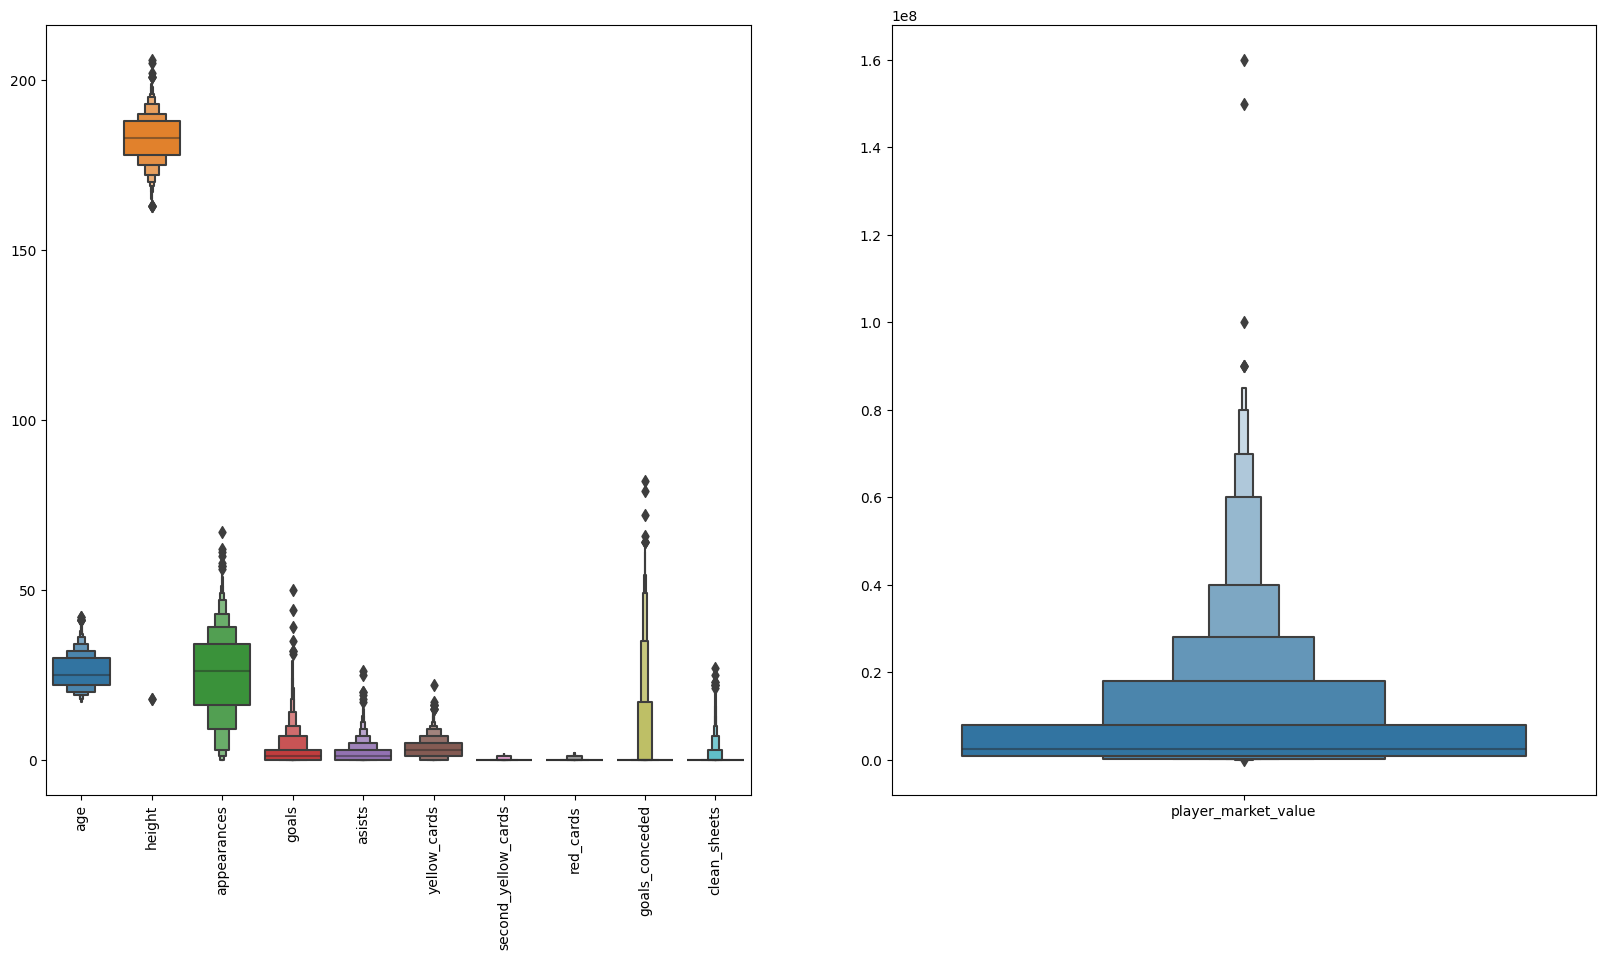

In [23]:
fig, axes = plt.subplots(ncols=2,figsize = (20, 10))
sns.boxenplot(df_copy[cols], ax = axes[0])
sns.boxenplot(df_copy[['player_market_value']],ax = axes[1])
axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=90)
plt.show()

In [24]:
df_copy = df_copy.drop(['player_id','given_name'],axis=1)

In [25]:
cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = list(set(df_copy.columns) - set(cat_cols))

le = preprocessing.LabelEncoder()
std_scaler = preprocessing.StandardScaler()
df_copy.loc[:, cat_cols] = df_copy.loc[:, cat_cols].apply(le.fit_transform)
df_copy.loc[:, num_cols] = std_scaler.fit_transform(df_copy.loc[:, num_cols])
df_copy.head()

,citizenship,age,foot,height,position_name,appearances,goals,asists,yellow_cards,second_yellow_cards,red_cards,goals_conceded,clean_sheets,player_market_value
0,11,0.616629,1,0.679403,6,1.922270,-0.627023,-0.716028,0.19665,-0.2771,-0.292533,3.840388,10.750495,2.905449
1,106,0.415421,2,1.073070,6,-1.299862,-0.627023,-0.716028,-0.80238,-0.2771,-0.292533,0.757438,0.636428,-0.109347
2,36,2.226289,2,0.679403,6,-1.944289,-0.627023,-0.716028,-1.13539,-0.2771,-0.292533,-0.270212,0.196686,-0.549971
3,90,-1.194239,2,0.023290,6,-0.413776,-0.627023,-0.716028,-0.46937,-0.2771,-0.292533,3.223798,2.835138,-0.379905
4,87,0.013006,2,0.548180,3,1.197290,-0.163469,1.108270,0.86267,-0.2771,-0.292533,-0.270212,-0.243057,5.224523


KPrototypes

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initializati

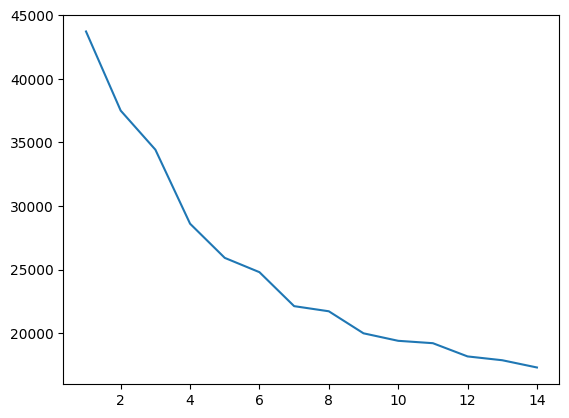

In [29]:
cost = []
for num_clusters in list(range(1,15)):
    kpro = KPrototypes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1, n_jobs=-1)
    kpro.fit_predict(df_copy, \
                      categorical = [df_copy.columns.get_loc(c) for c in cat_cols])
    cost.append(kpro.cost_)

y = np.array([i for i in range(1,15)])
plt.plot(y,cost)
plt.show()

In [30]:
kpro_cluster = KPrototypes(n_clusters=4, init = "Cao", n_init = 1, verbose=1)
kpro_cluster_pred = kpro_cluster.fit_predict(df_copy, \
                      categorical = [df_copy.columns.get_loc(c) for c in cat_cols] )

clustersDf = pd.DataFrame(kpro_cluster_pred)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([df_copy, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index'], axis = 1)
combinedDf.head()

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 765, ncost: 30781.580650005657
Run: 1, iteration: 2/100, moves: 272, ncost: 29981.68597129138
Run: 1, iteration: 3/100, moves: 233, ncost: 28787.736224291988
Run: 1, iteration: 4/100, moves: 115, ncost: 28703.338660809237
Run: 1, iteration: 5/100, moves: 93, ncost: 28659.418396078425
Run: 1, iteration: 6/100, moves: 68, ncost: 28641.03272353633
Run: 1, iteration: 7/100, moves: 62, ncost: 28624.441809312466
Run: 1, iteration: 8/100, moves: 50, ncost: 28615.711368962668
Run: 1, iteration: 9/100, moves: 32, ncost: 28612.355680923054
Run: 1, iteration: 10/100, moves: 29, ncost: 28609.091390767335
Run: 1, iteration: 11/100, moves: 14, ncost: 28608.308412066064
Run: 1, iteration: 12/100, moves: 8, ncost: 28608.011165824024
Run: 1, iteration: 13/100, moves: 11, ncost: 28607.079743575556
Run: 1, iteration: 1

,citizenship,age,foot,height,position_name,appearances,goals,asists,yellow_cards,second_yellow_cards,red_cards,goals_conceded,clean_sheets,player_market_value,cluster_predicted
0,11,0.616629,1,0.679403,6,1.922270,-0.627023,-0.716028,0.19665,-0.2771,-0.292533,3.840388,10.750495,2.905449,0
1,106,0.415421,2,1.073070,6,-1.299862,-0.627023,-0.716028,-0.80238,-0.2771,-0.292533,0.757438,0.636428,-0.109347,3
2,36,2.226289,2,0.679403,6,-1.944289,-0.627023,-0.716028,-1.13539,-0.2771,-0.292533,-0.270212,0.196686,-0.549971,3
3,90,-1.194239,2,0.023290,6,-0.413776,-0.627023,-0.716028,-0.46937,-0.2771,-0.292533,3.223798,2.835138,-0.379905,0
4,87,0.013006,2,0.548180,3,1.197290,-0.163469,1.108270,0.86267,-0.2771,-0.292533,-0.270212,-0.243057,5.224523,2


In [32]:
cluster_0 = combinedDf[combinedDf['cluster_predicted'] == 0]
cluster_0.head()

,citizenship,age,foot,height,position_name,appearances,goals,asists,yellow_cards,second_yellow_cards,red_cards,goals_conceded,clean_sheets,player_market_value,cluster_predicted
0,11,0.616629,1,0.679403,6,1.922270,-0.627023,-0.716028,0.19665,-0.2771,-0.292533,3.840388,10.750495,2.905449,0
3,90,-1.194239,2,0.023290,6,-0.413776,-0.627023,-0.716028,-0.46937,-0.2771,-0.292533,3.223798,2.835138,-0.379905,0
39,11,0.817836,2,1.335515,6,2.325036,-0.627023,-0.716028,-1.13539,-0.2771,-0.292533,3.943153,11.629979,3.291961,0
42,11,-1.194239,2,1.335515,6,-0.252670,-0.627023,-0.716028,-1.13539,-0.2771,-0.292533,3.943153,1.955654,-0.565431,0
44,36,-1.395447,1,0.941848,6,-0.011010,-0.627023,-0.716028,-1.13539,-0.2771,-0.292533,3.326563,2.835138,-0.379905,0


PCA

In [33]:
from sklearn.decomposition import PCA
pca_transformer = PCA(n_components=3,)
X = combinedDf.drop('cluster_predicted', axis=1)
reduced_X = pca_transformer.fit_transform(X)
reduced_df = pd.DataFrame(reduced_X, columns=['col1', 'col2', 'col3'])
reduced_df['cluster_predicted'] = combinedDf.cluster_predicted
print(reduced_df)

           col1      col2      col3  cluster_predicted
0     46.302826  0.681004 -2.387529                  0
1    -48.704195  0.347906 -1.918970                  3
2     21.294309  0.535437 -2.158102                  3
3    -32.705718  0.477023 -2.567925                  0
4    -29.680055 -2.622499  3.195606                  2
...         ...       ...       ...                ...
3646  -3.694512 -1.635058  0.790104                  2
3647 -41.694587 -1.674948  1.082195                  1
3648 -39.702335 -1.593555 -1.574929                  3
3649  14.297723 -1.548798 -2.332646                  3
3650 -39.702580 -1.534544 -1.815705                  3

[3651 rows x 4 columns]


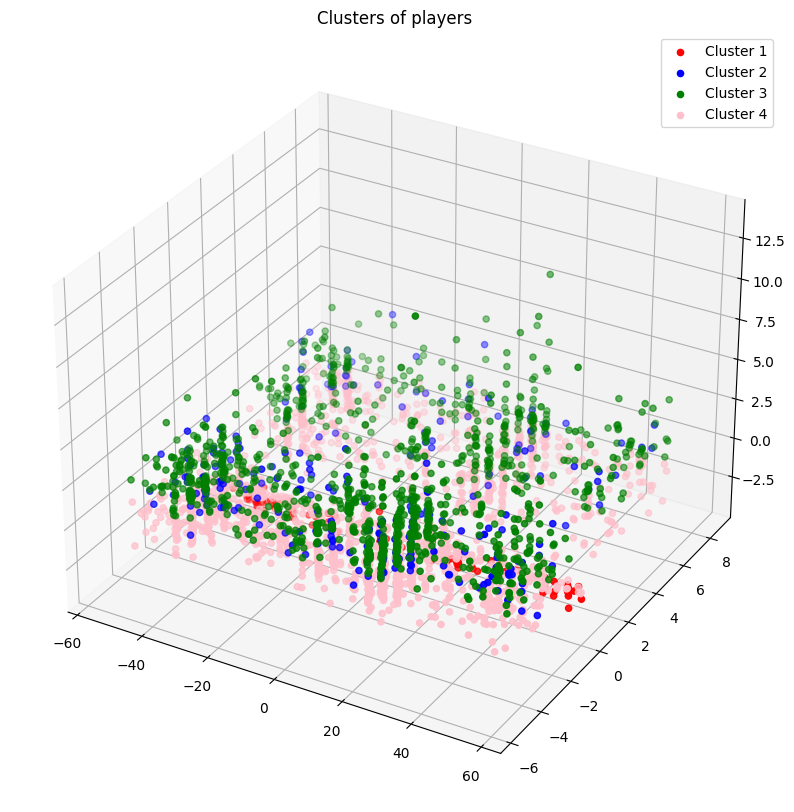

In [34]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.scatter3D(reduced_df.loc[reduced_df.cluster_predicted==0, 'col1'], reduced_df.loc[reduced_df.cluster_predicted==0, 'col2'],\
             reduced_df.loc[reduced_df.cluster_predicted==0, 'col3'], label= 'Cluster 1', c='red')
ax.scatter3D(reduced_df.loc[reduced_df.cluster_predicted==1, 'col1'], reduced_df.loc[reduced_df.cluster_predicted==1, 'col2'],\
             reduced_df.loc[reduced_df.cluster_predicted==1, 'col3'], label= 'Cluster 2', c='blue')
ax.scatter3D(reduced_df.loc[reduced_df.cluster_predicted==2, 'col1'], reduced_df.loc[reduced_df.cluster_predicted==2, 'col2'],\
             reduced_df.loc[reduced_df.cluster_predicted==2, 'col3'], label= 'Cluster 3', c='green')
ax.scatter3D(reduced_df.loc[reduced_df.cluster_predicted==3, 'col1'], reduced_df.loc[reduced_df.cluster_predicted==3, 'col2'],\
             reduced_df.loc[reduced_df.cluster_predicted==3, 'col3'], label= 'Cluster 4', c='pink')
plt.title('Clusters of players')
plt.legend()
plt.show()